In [1]:
import charts_function_list
import os

In [2]:
base_path,data,_ = charts_function_list.folder_setup()

In [4]:
os.chdir(data)

In [5]:
board_games = pd.read_csv('bgg_db_2017_04.csv',encoding='latin-1')

### Some initial explorations

In [70]:
board_games.corr()[board_games.corr()>.5].fillna('')

,rank,game_id,min_players,max_players,avg_time,min_time,max_time,year,avg_rating,geek_rating,num_votes,age,owned,weight
rank,1,,,,,,,,,,,,,
game_id,,1,,,,,,,,,,,,
min_players,,,1,,,,,,,,,,,
max_players,,,,1,,,,,,,,,,
avg_time,,,,,1,0.873736,0.999909,,,,,,,
min_time,,,,,0.873736,1,0.873613,,,,,,,
max_time,,,,,0.999909,0.873613,1,,,,,,,
year,,,,,,,,1,,,,,,
avg_rating,,,,,,,,,1,,,,,0.538311
geek_rating,,,,,,,,,,1,0.636099,,0.629257,


### A look at the top most prolific designers' games

In [6]:

board_games = board_games[~board_games['designer'].isin(['(Uncredited)','none'])].reset_index(drop=True)
#board_games = board_games[board_games['num_votes']>=board_games['num_votes'].median()]  #filter to only include games rated > than median

rating_group_ = board_games.groupby('designer')
agg_funcs = {'geek_rating':np.mean,'names':np.count_nonzero}
rating_frame = rating_group_.agg(agg_funcs)
rating_frame.sort_values(by='names',ascending=False,inplace=True)

def top_ratings(df_ranks,df_full,values=5):
    top_list = df_ranks.head(values)
    top_df = df_full[df_full['designer'].isin(top_list.index)].reset_index(drop=True)
    design_map = {v:i for i,v in enumerate(top_df['designer'].unique())}
    top_df.loc[:,'cmap'] = top_df['designer'].map(design_map)
    return top_df

In [7]:
top_5_ratings = top_ratings(rating_frame,board_games,values=5)
top_10_ratings = top_ratings(rating_frame,board_games,values=10)

In [36]:
top_10_ratings.groupby('designer').median()['geek_rating'].sort_values(ascending=True)

designer
Richard H. Berg                      5.740
Dan Verssen                          5.818
Michael Schacht                      5.932
Reiner Knizia                        5.984
Klaus Teuber                         5.994
Friedemann Friese                    6.109
Martin Wallace                       6.231
Michael Kiesling, Wolfgang Kramer    6.265
Uwe Rosenberg                        6.562
Stefan Feld                          6.755
Name: geek_rating, dtype: float64

In [8]:
charts_function_list.available_fonts()

{'AR BERKLEY',
 'AR BLANCA',
 'AR BONNIE',
 'AR CARTER',
 'AR CENA',
 'AR CHRISTY',
 'AR DARLING',
 'AR DECODE',
 'AR DELANEY',
 'AR DESTINE',
 'AR ESSENCE',
 'AR HERMANN',
 'AR JULIAN',
 'Adventure',
 'Agency FB',
 'Algerian',
 'Arial',
 'Arial Rounded MT Bold',
 'Arial Unicode MS',
 'Baskerville Old Face',
 'Bauhaus 93',
 'Bell MT',
 'Berlin Sans FB',
 'Berlin Sans FB Demi',
 'Bernard MT Condensed',
 'Blackadder ITC',
 'Bodoni MT',
 'Book Antiqua',
 'Bookman Old Style',
 'Bookshelf Symbol 7',
 'Bradley Hand ITC',
 'Britannic Bold',
 'Broadway',
 'Brush Script MT',
 'Calibri',
 'Californian FB',
 'Calisto MT',
 'Cambria',
 'Candara',
 'Castellar',
 'Centaur',
 'Century',
 'Century Gothic',
 'Century Schoolbook',
 'Chiller',
 'Colonna MT',
 'Comic Sans MS',
 'Consolas',
 'Constantia',
 'Cooper Black',
 'Copperplate Gothic Bold',
 'Copperplate Gothic Light',
 'Corbel',
 'Courier New',
 'Curlz MT',
 'DejaVu Sans',
 'DejaVu Sans Display',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'DejaVu Ser

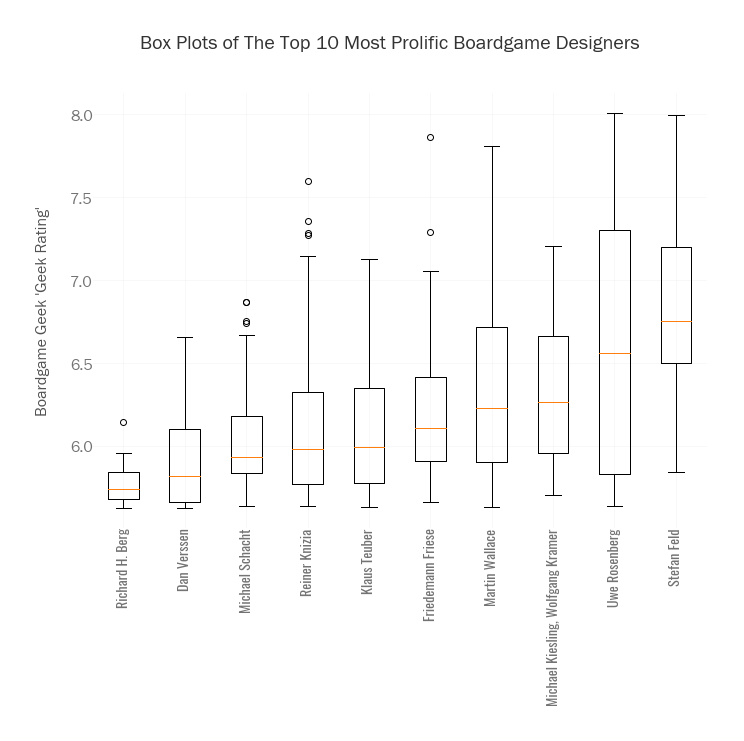

In [26]:
data = []

box_plots_ = charts_function_list.chart_maker('Box Plots of The Top 10 Most Prolific Boardgame Designers',title_size=20)
fig = box_plots_.initial_fig_axis(figsize=(11,8))
ax = box_plots_.axes_set_up(fig)

ranked_names = top_10_ratings.groupby('designer').median()['geek_rating'].sort_values(ascending=True).index
for i in ranked_names:
    data.append(top_10_ratings[top_10_ratings['designer']==i]['geek_rating'])
plt.boxplot(data,meanline=True)
#ax.set_yticks([i for i,v in enumerate(ranked_names)])
box_plots_.tick_params_(ax,labelcolor='#737373')
ax.set_xticklabels(ranked_names,rotation=90,fontname='Oswald',weight='normal',fontsize=14)
ax.set_ylabel('Boardgame Geek \'Geek Rating\'',size=16,color='#525252',labelpad=20)
plt.show()

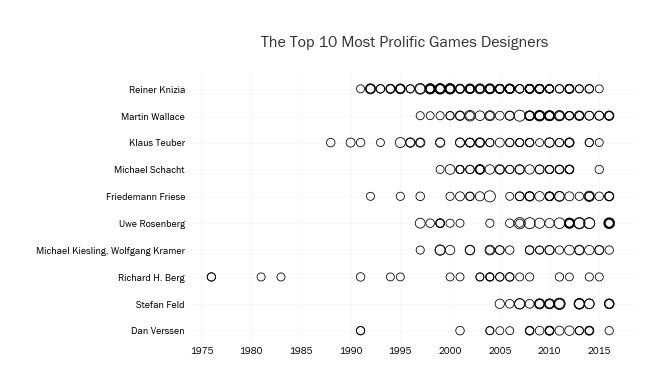

In [14]:
#playing with scatters

scatter_top = charts_function_list.chart_maker('The Top 10 Most Prolific Games Designers')
fig = scatter_top.initial_fig_axis(figsize=(8,5))
ax = scatter_top.axes_set_up(fig)

def top_scatters(df,cmap='Dark2'):
    value_counts_ = df['designer'].value_counts().sort_values(ascending=True)
    

    for i,v in enumerate(value_counts_):
        a = df[df['designer']==value_counts_.index[i]]
        plt.scatter(a['year'],
                    np.linspace(i,i,len(a)),
                   s=(a['geek_rating']**2)*2,facecolor='none',edgecolor='black',linewidth=.8)
        
    return value_counts_

abc = top_scatters(top_10_ratings)
ax.set_yticks([i for i,v in enumerate(abc.index)])
ax.set_yticklabels([v for i,v in enumerate(abc.index)])

plt.show()


#box plots .. 

### Preliminary look at top board game designers with k-means

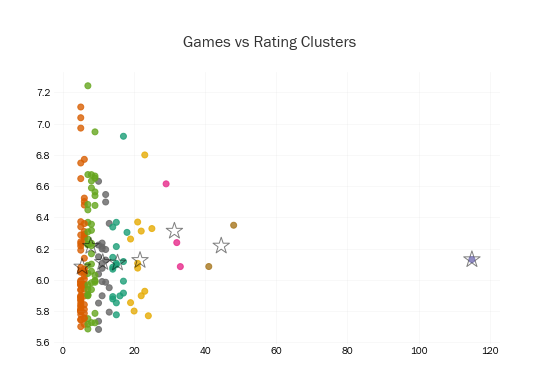

In [11]:
#assess via kmeans

top_designers = board_games['designer'].value_counts()[board_games['designer'].value_counts()>=5]
board_games_top_design=board_games[board_games['designer'].isin(top_designers.index)]

rating_group_top = board_games_top_design.groupby('designer')

rating_frame_top = rating_group_top.agg(agg_funcs)



from sklearn.cluster import KMeans

f1 = rating_frame_top['geek_rating'].values
f2 = rating_frame_top['names'].values

X=np.matrix(list(zip(f1,f2)))
kmeans = KMeans(n_clusters=8,algorithm='auto',n_init=50).fit(X)

chart_object = charts_function_list.chart_maker('Games vs Rating Clusters')
fig = chart_object.initial_fig_axis(figsize=(8,5))
ax = chart_object.axes_set_up(fig)
ax.scatter(f2,f1,alpha=.8,c=kmeans.labels_,zorder=1,cmap='Dark2')
for x,y in kmeans.cluster_centers_ :
    ax.scatter(y,x,marker='*',facecolors='none',s=300,zorder=2,alpha=.5,edgecolor='black')
plt.show()


In [334]:
kmeans.labels_

array([0, 0, 2, 6, 0, 0, 3, 0, 7, 3, 0, 7, 2, 0, 3, 0, 0, 7, 3, 0, 3, 0, 7,
       0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 7, 6, 0, 0, 0, 6, 2, 0, 0, 0, 3, 2, 7,
       2, 7, 7, 7, 0, 7, 7, 0, 3, 0, 0, 7, 3, 7, 4, 0, 6, 7, 0, 0, 7, 0, 6,
       0, 0, 3, 0, 3, 6, 0, 3, 0, 6, 7, 7, 0, 0, 7, 3, 7, 0, 0, 7, 6, 0, 7,
       0, 0, 3, 5, 6, 7, 3, 0, 0, 6, 7, 7, 0, 0, 0, 3, 0, 0, 5, 3, 7, 7, 7,
       2, 0, 3, 0, 4, 6, 7, 7, 7, 0, 0, 7, 0, 7, 7, 7, 1, 7, 7, 6, 7, 6, 2,
       6, 3, 7, 2, 7, 3, 3, 0, 6, 2, 2, 0, 0, 7, 7, 2, 0, 3, 6, 0, 6, 7, 7,
       0, 0, 0, 0, 3, 4, 0, 6, 0, 2])

In [387]:
data = []
for item in top_5_full_data['designer'].unique():
    data.append(top_5_full_data[top_5_full_data['designer']==item]['geek_rating'])
plt.boxplot(data,
plt.show()
#top_5_full_data[top_5_full_data['designer']]

TypeError: boxplot() got an unexpected keyword argument 'c'